In [14]:
# coding: utf-8
import matplotlib.pyplot as plt

import datetime
import pandas as pd
from pathlib import Path
import degiro_wrapper as dw
import logging

plt.ion()

logging.info("Reading config.")

CONFIG_DIR = "/Users/mmngreco/github/mmngreco/degiro-wrapper/degiro.ini"
CONFIG_SECTION = "DEGIRO"

ISIN_CASH = dw.conventions.ISIN_CASH

config = dw.api_methods.get_config(CONFIG_DIR)
user_data = dw.api_methods.get_login_data(config=config)

path = Path(config[CONFIG_SECTION]["files_dir"]).expanduser().absolute()
if not path.exists():
    path.mkdir()

date_start = "20191001"
date_end = datetime.datetime.today()
calendar = pd.date_range(start=date_start, end=date_end, freq="B")

logging.info("Downloading data")
dw.api_methods.download_positions(
    calendar=calendar,
    path=path,
    data=user_data,
    filename_template="pos_%Y%m%d",
)

positions_raw_df = dw.preprocess.positions_xls_to_df(path, isin_cash=ISIN_CASH)
cleaned_data = dw.preprocess.positions_raw_to_clean(positions_raw_df)

amount_df = cleaned_data["amount"]
prices_df = cleaned_data["prices"]
shares_df = cleaned_data["shares"]
nav_df = cleaned_data["nav"]
rets_df = cleaned_data["returns"]

path_account = dw.api_methods.download_cashflows(user_data, date_start, date_end, path)
cf = dw.preprocess.generate_cashflows(path_account=path_account, isin_cash=ISIN_CASH)
cashflows_df = cf["cashflows"]
cashflows_external_df = cf["cashflows_external"]

# ??? : What means ss and why the following is needed
cashflows_ss = cashflows_df.drop(columns=ISIN_CASH).sum(axis=1)
cashflows_total_ss = (
    cashflows_external_df.set_index("date")["amount"]
    .reindex(cashflows_ss.index, fill_value=0.0)
    .add(cashflows_ss)
)

cash_calendar = cashflows_total_ss.index
for today, yesterday in zip(cash_calendar[1:], cash_calendar):
    cash_today = amount_df.loc[today, ISIN_CASH]
    cash_yesterday = amount_df.loc[yesterday, ISIN_CASH]

    flows = cashflows_total_ss.loc[today]

    rets_df.loc[today, ISIN_CASH] = (cash_today - flows) / cash_yesterday - 1


logging.info("Compute performance")

weights_df = amount_df.div(amount_df.sum(axis=1), axis="index").shift(1)
weights_df = weights_df.rename(columns={ISIN_CASH: "Cash"})

INFO:root:Reading config.
INFO:root:Config file processed
INFO:root:Config loaded correctly for user: msvalero.
INFO:root:Downloading data
100%|██████████| 144/144 [00:00<00:00, 12591.83it/s]
INFO:root:Compute performance


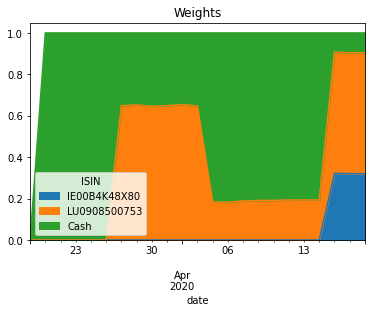

In [15]:
weights_df.plot.area(title="Weights")

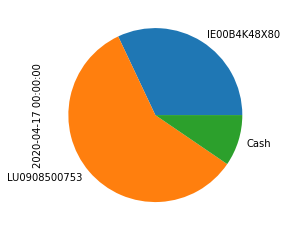

In [16]:
weights_df.tail(1).T[weights_df.index[-1]].plot.pie();

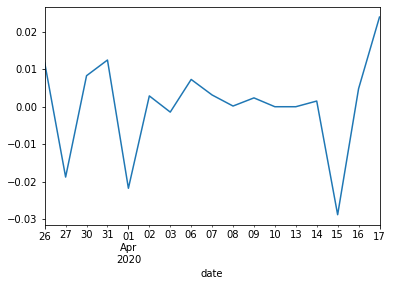

In [17]:
pf_returns_ss = (rets_df * weights_df).dropna(how="all").sum(axis=1)
pf_returns_ss.plot();

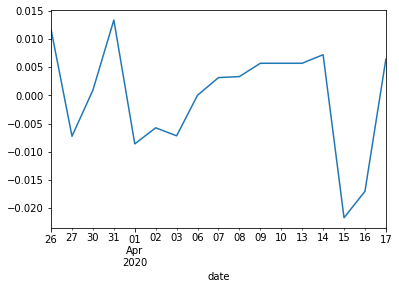

In [13]:
pf_equity_ss = pf_returns_ss.add(1).cumprod().sub(1)
pf_equity_ss.plot();